# Reproduce  H. Huang , et. al , Faraday Discuss., 2018, 208, 555 – 573 

This notebook demonstrates reproducing the results of the paper with [Larch](https://xraypy.github.io/xraylarch/xafs/) using the corresponding published dataset (raw data). 


Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) **Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study.** Faraday Discussions. V. 208. pp. 555-573. DOI: [10.1039/c7fd00221a](https://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.


For more details about Larch, see [Larch Website](https://xraypy.github.io/xraylarch/xafs/)

## Reproduce Figure 4 - XANES Analysis
The first set of XAS results in the paper are in [Figure 4](https://pubs.rsc.org/image/article/2018/fd/c7fd00221a/c7fd00221a-f4_hi-res.gif)

To reproduce this image we need to:
- A: Identify the XANES data used (SnO2, Air, Ar, H2 and Sn foil)
  - Plot normalised flattened mE of the spectra on the range 29190 – 29450 
  - Plot first derivate of the spectra on the range 29190 – 29215
- B: Take Sn foil and SnO2 and do LCF of the peaks against H2, Ar, and Air
- C: Take Sn K-Edge of H2/H2 and SnO2 and do LCF of the peaks against H2, Ar, and Air

|Key|Content|
|:--|:--|
|OC|parent|
|OCA| Ar treated|
|OCH| H2 treated|
|OCO|air-treated|

In [1]:
# Library with the functions that rplicate those provided by athena
# normalisation, merging, re-binning, LCF
# and visualisation (plotting)
import lib.manage_athena as athenamgr  

# File handling
from pathlib import Path

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

### Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

### Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch provinding the custom column names. 

We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


In [2]:
# variables that can be changed to process different datasets
data_path = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii"

data_mappings={"PtSn":  "*_PtSn_OC_A*",
              "Air":  "*_PtSn_OCO_A*",
              "Ar":  "*_PtSn_OCA_A*",
              "H2":  "*_PtSn_OCH_A*",
              "PtSn H":  "*_PtSn_OC_H*", 
              "Air H":  "*_PtSn_OCO_H*",
              "Ar H":  "*_PtSn_OCA_H*",
              "H2 H":  "*_PtSn_OCH_H*",}

f_prefix = "PtSn_KEdge"
column_labels = "energy time I0 It Iref  mu lnItIref"

show_graph = True # False to prevent showing graphs

### Get fata and merge results for each sample in list
The below reads the raw readings for eache of the samples in data mappings and merges them to create the signals to be processed.



In [3]:
# start processing createa an output dir and sets the logger
source_path, out_path = athenamgr.files_setup(f_prefix, data_path)
print(source_path, out_path)


merged_results={}
# read all samples, merge and then normalise
for a_sample in data_mappings:
    files_list = athenamgr.get_files_list(source_path, data_mappings[a_sample])

    # read the files for each sample

    sample_list = []

    for i_count, a_file  in enumerate(files_list):
        file_name = a_file.name
        f_suffix = str(i_count).zfill(4) 
        p_name = f_prefix+f_suffix
        p_path = Path(out_path , p_name + ".prj")
        a_group = athenamgr.read_text(a_file, column_labels)
        sample_list.append(a_group)
        
    # merge readings for sample
    merged_xas = athenamgr.merge_readings(sample_list)

    # rename group (same as the file name)
    merged_xas.filename = a_sample
    merged_results[a_sample] = merged_xas
    # calculate pre-edge and post edge and add them to group
    # using defaults
    xas_data = athenamgr.fit_pre_post_edge(merged_xas)

# results in the paper are recalibrated to 29204
recalibrate_e0_to = 29204

for a_sample in merged_results:
    merged_results[a_sample] = athenamgr.recalibrate_energy(merged_results[a_sample], recalibrate_e0_to)


C:\harwell\PSDI_test\wf_data\pub_037\XAFS_prj\Sn K-edge\ascii PtSn_KEdge


### Get standards
The code below reads the Sn Foil and SnO2 project and retrieves the foil data used to copare to the readings


In [4]:
# get the Sn foil from project:
sn_foil = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn foil.prj"
# read the input file 
sn_foil_prj = athenamgr.read_project(sn_foil)

sn_foil_group = athenamgr.get_group(sn_foil_prj, 'merge')
sn_foil_group.filename = "Sn Foil"
sn_foil_group = athenamgr.recalibrate_energy(sn_foil_group, recalibrate_e0_to)
merged_results["Sn Foil"] = sn_foil_group

# get the Sn O2 standard from project:
sno2 = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/SnO2 0.9 2.6-13.5 gbkg.prj"
# read the input file 
sno2_prj = athenamgr.read_project(sno2)

sno2_group = athenamgr.get_group(sno2_prj, "SnO2_0_9_2_6_13_5_0_8_1_0_with_theory")#'SnO2_0_9')
sno2_group.filename = "SnO2"
sno2_group = athenamgr.recalibrate_energy(sno2_group, recalibrate_e0_to)
merged_results["SnO2"] = sno2_group

### Plot the mu signals for the reading and the Sn Foil

These are the plots shown on Fig. 4 A

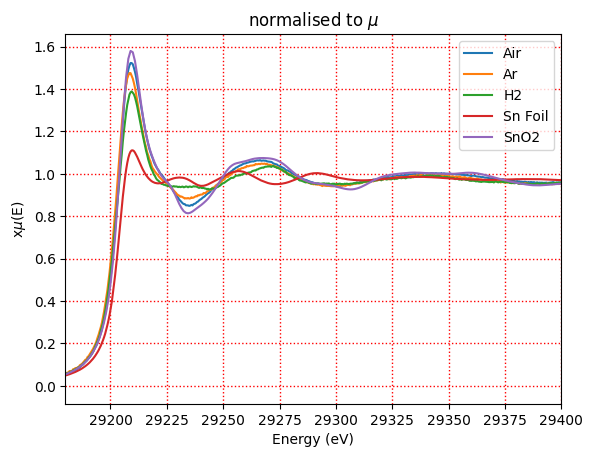

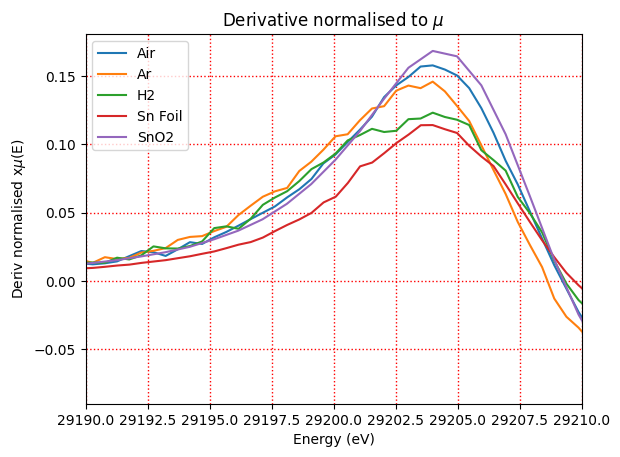

In [5]:
include_groups = ["Air", "Ar", "H2", "Sn Foil", "SnO2"]
for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_normalised(merged_results[a_sample])
    
plt.xlim([29180, 29400])
plt.show()

for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_derivative(merged_results[a_sample])
    
plt.xlim([29190, 29210])
plt.show()

### Linear combination fitting (LCF)
Lineal combination fitting with defaults for the H2, Ar and Air readings (Shown on Fig. 4 B)

In [6]:
# these functions are only used here to create the plot with three subplots for the paper
def make_subplot(a_subplt, group1, group2):
    a_subplt.plot(group1.energy, group1.norm, label=group1.filename, linewidth=4,color='blue')
    a_subplt.plot(group2.energy, group2.norm, label=group2.filename, linewidth=2, color='orange',linestyle='--')
    a_subplt.grid(color='black', linestyle=':', linewidth=1) #show and format grid
    a_subplt.set_title(group2.arrayname, fontsize=8)
    a_subplt.legend() # show legend
     
    a_subplt.set_xlim([29190, 29230])
    #a_subplt.set_ylim([0, 1.5])
    #a_subplt.tick_params(axis='both', which='major', labelsize=9)
    #xlabels = a_subplt.get_xticklabels()
    #a_subplt.set_xticks(xlabels, rotation = 90)
    return a_subplt

def make_main_plot(lcf_1, lcf_2, lcf_3):
    fig, axes = plt.subplots(1,3, constrained_layout=True)
    axes[0] = make_subplot(axes[0], lcf_1[0], lcf_1[1])
    axes[1] = make_subplot(axes[1], lcf_2[0], lcf_2[1])
    axes[2] = make_subplot(axes[2], lcf_3[0], lcf_3[1])
    return fig

In [7]:
lcf_components = [merged_results["Sn Foil"],merged_results["SnO2"]] # List of groups to use as components 
r_H2 = athenamgr.lcf_group(merged_results["H2"], lcf_components)
r_Ar = athenamgr.lcf_group(merged_results["Ar"], lcf_components)
r_Air = athenamgr.lcf_group(merged_results["Air"], lcf_components)

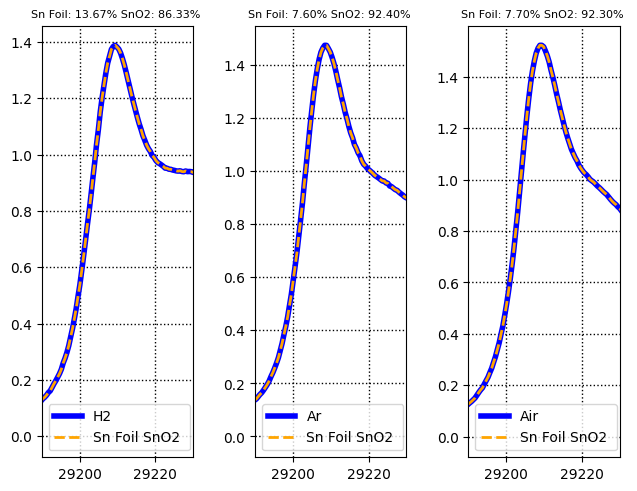

Sn Foil: 13.67% SnO2: 86.33% 


In [8]:
make_main_plot([merged_results["H2"],r_H2], [merged_results["Ar"],r_Ar], [merged_results["Air"],r_Air])
plt.show()

print(r_H2.arrayname)

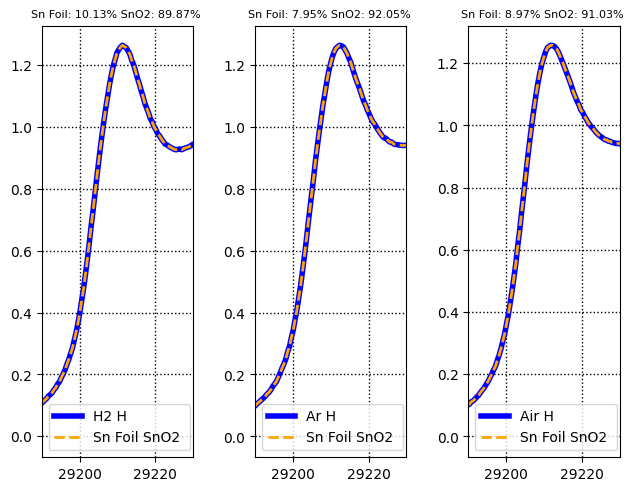

In [9]:
r_HH2 = athenamgr.lcf_group(merged_results["H2 H"], lcf_components)
r_HAr = athenamgr.lcf_group(merged_results["Ar H"], lcf_components)
r_HAir = athenamgr.lcf_group(merged_results["Air H"], lcf_components)

make_main_plot([merged_results["H2 H"],r_HH2], [merged_results["Ar H"],r_HAr], [merged_results["Air H"],r_HAir])
plt.show()

In [10]:
print("Goodness of LCF fits")
print ("LCF for H2:\t", "%.4f" % r_H2.rfactor)
print ("LCF for Ar:\t", "%.4f" % r_Ar.rfactor)
print ("LCF for Air:\t", "%.4f" % r_Air.rfactor)
print ("LCF for H\\H2:\t","%.4f" % r_HH2.rfactor)
print ("LCF for H\\Ar:\t","%.4f" % r_HAr.rfactor)
print ("LCF for H\\Air:\t","%.4f" % r_HAir.rfactor)


Goodness of LCF fits
LCF for H2:	 0.0007
LCF for Ar:	 0.0004
LCF for Air:	 0.0004
LCF for H\H2:	 0.0023
LCF for H\Ar:	 0.0028
LCF for H\Air:	 0.0026


## Reproduce Figure 5 XAS Processing
Rebin is required for XAS processing (see [Athena Manual](https://bruceravel.github.io/demeter/documents/Athena/process/rebin.html). So after the XANES analysis

In [11]:
# Rebin Ar, Air and H2 Samples 
rebin_labels = ["H2", "Ar", "Air"]
rebinned_groups = {}
rebinned_gr=None
for a_sample in merged_results:
    if a_sample in rebin_labels:
        rebinned_gr = athenamgr.rebin_group(merged_results[a_sample])
        rebinned_gr.arrayname = a_sample+" Rebbined"
        rebinned_groups[a_sample+" Rebbined"] = rebinned_gr
        print(len(rebinned_gr.energy),"to", len(merged_results["Ar"].energy))

378 to 2093
378 to 2093
378 to 2093


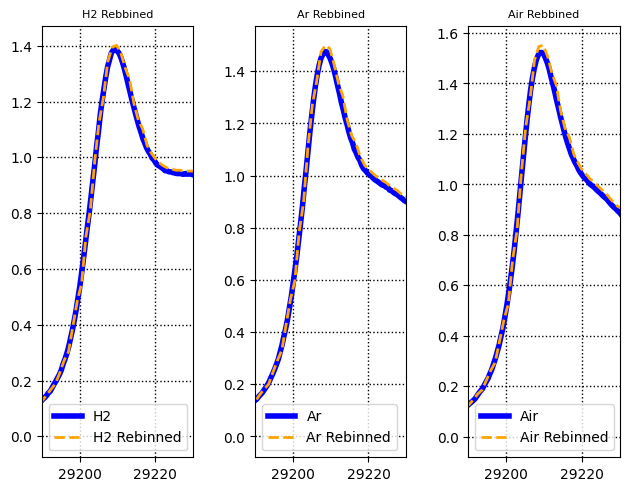

In [12]:
make_main_plot([merged_results["H2"],rebinned_groups["H2 Rebbined"]], 
               [merged_results["Ar"],rebinned_groups["Ar Rebbined"]], 
               [merged_results["Air"],rebinned_groups["Air Rebbined"]])
plt.show()

In [13]:
# Fitting input variables
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395.cif"] #Pt3Sn

gds_parms_f = "SnK_edge_gds.csv"
sel_paths_f = "SnK_edge_sp.csv"

show_graph = False # False to prevent showing graphs

# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0

# Need to specify the absorbing atom and maximum radius
absorbing_atom = "Pt" 
max_radius = 8.0

## Atoms and FEFF

Larch does larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.


In [14]:
# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files, absorbing_atom, max_radius)

cif
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : comment: None given
 : Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1692395.cif
 : Structure Summary:  Sn1 Pt3
 : Reduced formula:  SnPt3
 : space group: (Pm-3m), space number:  (221)
 : abc:  3.967000   3.967000   3.967000
 : angles: 90.000000  90.000000  90.000000
 : sites: 4
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique 

 : 115     1.248    32.000     3   7.5426 neglected
 : 116     1.834    32.000     3   7.5426 neglected
 : 117     0.072    32.000     5   7.5937 neglected
 : 118     0.074    16.000     5   7.5937 neglected
 : 119     0.053    32.000     5   7.5937 neglected
 : 120     0.126    32.000     5   7.5937 neglected
 : 121     0.305    32.000     4   7.6637 neglected
 : 122     0.216    32.000     4   7.6637 neglected
 : 123     0.267    32.000     4   7.6637 neglected
 : 124     0.140    32.000     4   7.6637 neglected
 : 125     0.138    32.000     4   7.6637 neglected
 : 126     0.264    16.000     4   7.6637 neglected
 : 127     0.248    16.000     4   7.6637 neglected
 : 128     0.108    32.000     4   7.6637 neglected
 : 129     0.073    32.000     4   7.6637 neglected
 : 130     0.070    32.000     4   7.6637 neglected
 : 131     0.473    16.000     4   7.6637 neglected
 : 132     1.020    16.000     4   7.6637 neglected
 : 133     0.498    32.000     4   7.6637 neglected
 : 134     0

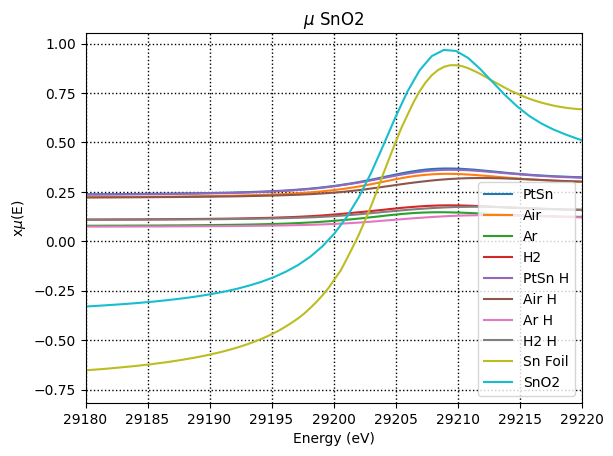

PtSn 29204 points: 2093
Air 29204 points: 2093
Ar 29204 points: 2093
H2 29204 points: 2093
PtSn H 29204 points: 2093
Air H 29204 points: 2093
Ar H 29204 points: 2093
H2 H 29204 points: 2093
Sn Foil 29204 points: 2064
SnO2 29204 points: 1047


(29180.0, 29220.0)

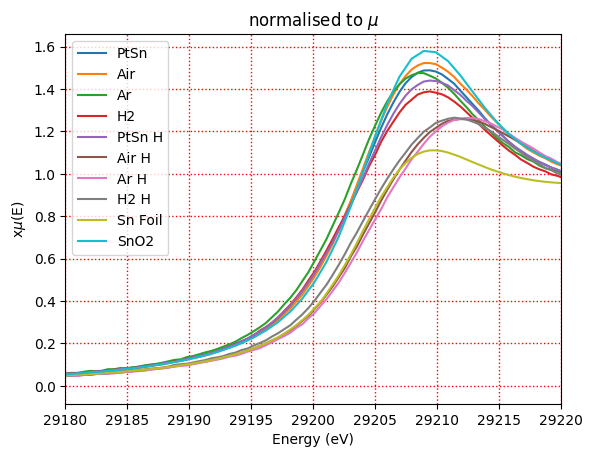

In [15]:
for a_sample in merged_results:
    plt = athenamgr.plot_mu(merged_results[a_sample])

plt.xlim([29180, 29220])
plt.show()
for a_sample in merged_results:
    print(merged_results[a_sample].filename, merged_results[a_sample].e0, 'points:', len(merged_results[a_sample].energy))
    plt = athenamgr.plot_normalised(merged_results[a_sample])

plt.xlim([29180, 29220])
#plt.show()

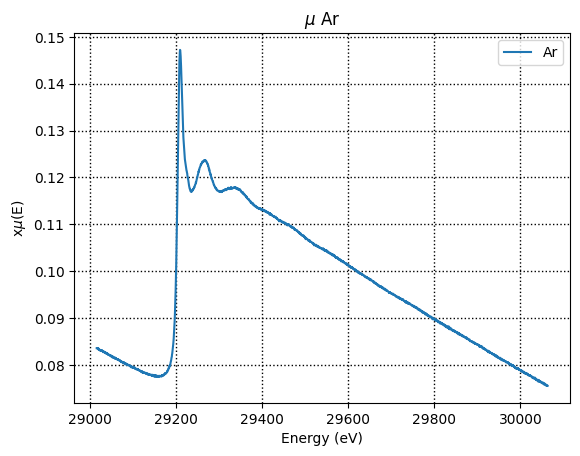

In [16]:
plt = athenamgr.plot_mu(merged_results["Ar"])
plt.show()

In [17]:
dir (merged_results["Ar Rebinned"].rebinned)

KeyError: 'Ar Rebinned'

In [ ]:
dir (merged_results["Ar Rebinned"])

In [ ]:
import random

print(random.randint(0, 3))

In [ ]:
len(merged_results["Ar Rebinned"].rebinned.delta_mu)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)


t1 = np.arange(0.0, 3.0, 0.02)

ax1 = plt.subplot(131)
ax1.margins(0.05)           # Default margin is 0.05, value 0 means fit
ax1.plot(t1, f(t1))

ax2 = plt.subplot(132)
ax2.margins(2, 2)           # Values >0.0 zoom out
ax2.plot(t1, f(t1))
ax2.set_title('Zoomed out')

ax3 = plt.subplot(133)
ax3.margins(x=0, y=-0.25)   # Values in (-0.5, 0.0) zooms in to center
ax3.plot(t1, f(t1))
ax3.set_title('Zoomed in')

plt.show()

In [ ]:
def example_plot(ax, fontsize=12, hide_labels=False):
    ax.plot([1, 2])

    ax.locator_params(nbins=3)
    if hide_labels:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    else:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)

fig, ax = plt.subplots(layout=None)
example_plot(ax, fontsize=24)
fig, axs = plt.subplots(1, 3, layout="constrained")
for ax in axs.flat:
    example_plot(ax, hide_labels=True)
fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0.2,
                            wspace=0.2)

In [ ]:
fig, axes = plt.subplots(1,3, constrained_layout=True)

plt.show()